In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas
import math
from tqdm.auto import tqdm

In [3]:
# Defining a Linear Congruence Generator
def uniform_generator(x):
    a = 1597
    c = 2330197
    m = 2**32
    x = (a*x + c)%m
    return x/m, x

In [4]:
# defining a normal generator using the Box-Muller method to sample from N(0, 1)
def normal_generator(x_1, x_2):
    u1, x_1 = uniform_generator(x_1)
    u2, x_2 = uniform_generator(x_2)
    r = math.sqrt(-2*math.log(u1))
    theta = 2*math.pi*u2
    return r*math.cos(theta), r*math.sin(theta), x_1, x_2

In [5]:
# Downloading data
ticker_symbol = '^SPX'
ticker = yf.Ticker(ticker_symbol)

historical_data = ticker.history(period="1y")  # data for the last year
print("Historical Data:")
print(historical_data)

stock_prices = np.array(historical_data['Close'])
stock_prices[:5]

Historical Data:
                                  Open         High          Low        Close  \
Date                                                                            
2023-10-30 00:00:00-04:00  4139.390137  4177.470215  4132.939941  4166.819824   
2023-10-31 00:00:00-04:00  4171.330078  4195.549805  4153.120117  4193.799805   
2023-11-01 00:00:00-04:00  4201.270020  4245.640137  4197.740234  4237.859863   
2023-11-02 00:00:00-04:00  4268.259766  4319.720215  4268.259766  4317.779785   
2023-11-03 00:00:00-04:00  4334.229980  4373.620117  4334.229980  4358.339844   
...                                ...          ...          ...          ...   
2024-10-23 00:00:00-04:00  5834.500000  5834.850098  5762.410156  5797.419922   
2024-10-24 00:00:00-04:00  5817.799805  5817.799805  5784.919922  5809.859863   
2024-10-25 00:00:00-04:00  5826.750000  5862.819824  5799.979980  5808.120117   
2024-10-28 00:00:00-04:00  5833.930176  5842.919922  5823.080078  5823.520020   
2024-10-29 

array([4166.81982422, 4193.79980469, 4237.85986328, 4317.77978516,
       4358.33984375])

In [6]:
R = [] # Daily returns.
for i in range(len(stock_prices) - 1):
    R.append((stock_prices[i+1] - stock_prices[i])/stock_prices[i])

mean = np.mean(R)
std = np.std(R)
print(mean, std)

0.0013673464181339055 0.007619051323558707


In [7]:
print(f" Parameters for GBM are (T, S(0), mu, sigma): ({len(stock_prices), stock_prices[0], mean, std}")

 Parameters for GBM are (T, S(0), mu, sigma): ((252, 4166.81982421875, 0.0013673464181339055, 0.007619051323558707)


  0%|          | 0/10 [00:00<?, ?it/s]

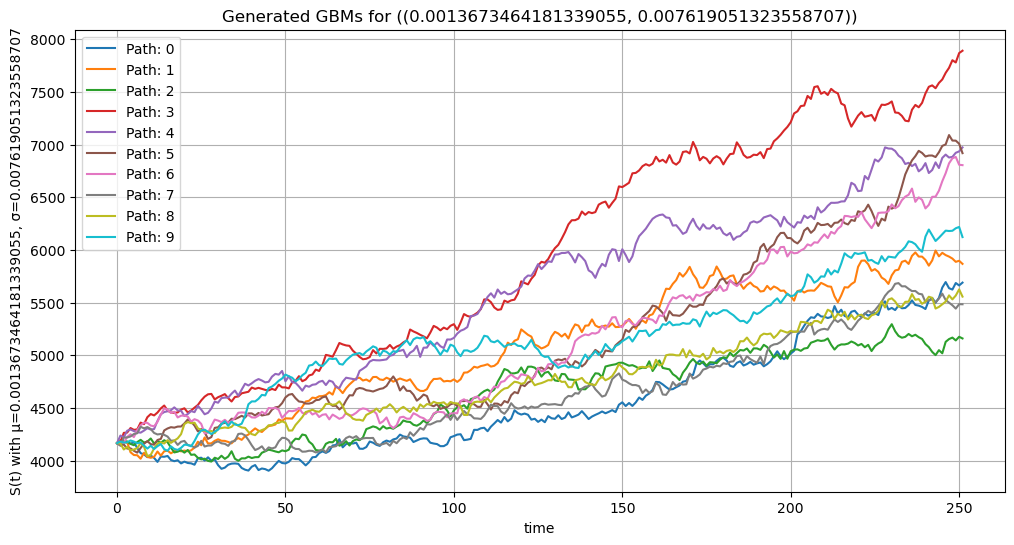

In [8]:
N = 10 # Set number of paths here, increase to make expectation congverge to 0.
np.random.seed(42)
t = [i for i in range(252)]
# print(t)
mu = mean
sigma = std
S = [[] for _ in range(N)]
seeds = np.random.rand(N) # Used only to get different values for the seeds, use only when N > 10.
seeds *= N
seeds //= 1
for path in tqdm(range(N)):
    S[path].append(stock_prices[0]) # Setting S[0] = initial stock price
    x1 = seeds[path]
    x2 = seeds[(path + 3)%N]
    # Now employing the recursive geometric brownian motion formula, S(ti+1) = S(ti)*exp{1/2(mu - sigma^2)*(ti+1 - ti) + sigma*sqrt(ti+1 - ti)*Z(i+1)
    for i in range(251):
        z = np.random.randn()
        Zi_1, Z_i_1, x1, x2 = normal_generator(x1, x2)
        S[path].append(S[path][i]*math.exp(((mu - (sigma**2)/2)*(t[i+1] - t[i])) + sigma*math.sqrt(t[i+1] - t[i])*z))

        
plt.figure(figsize=(12, 6))
for path in range(N):
    plt.plot(t, S[path], label=f'Path: {path}')

plt.title(f"Generated GBMs for ({mu, sigma})")
plt.xlabel('time')
plt.ylabel(f"S(t) with µ={mu}, σ={sigma}")
plt.grid(True)
plt.legend()
plt.show()

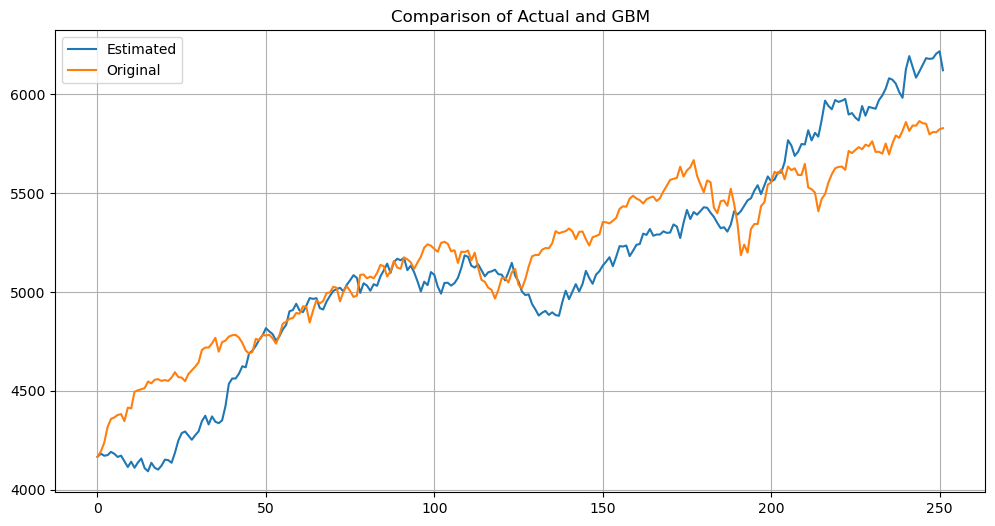

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(t, S[9], label="Estimated")
plt.plot(t, stock_prices, label="Original")
plt.legend()
plt.title("Comparison of Actual and GBM")
plt.grid(True)
plt.show()

## Q2

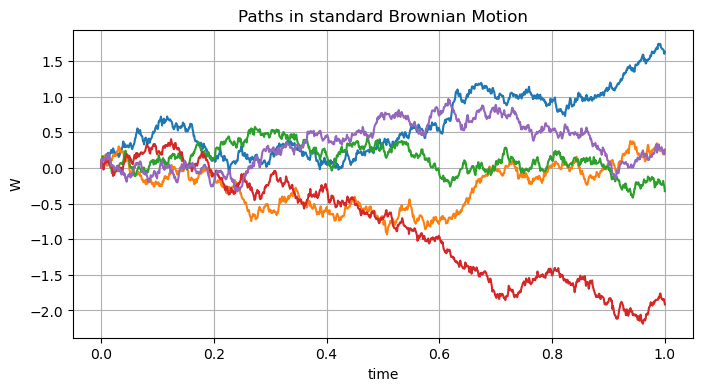

In [11]:
N = 5 # Set number of paths here, default given 5
np.random.seed(42)
t = [0.001*i for i in range(1001)]
# print(t)
W = [[] for _ in range(N)]

seeds = np.random.rand(N + 1) 
seeds *= 1000
seeds //= 1

for path in range (N):
    W[path].append(0) # Setting W(0) = 0
    x1 = seeds[path]
    x2 = seeds[(path + 3)%N]
    # Now empolying the recursive formula, W(ti+1) = W(ti) + sqrt(ti+1 - ti)*Z(i+1)
    for i in range(1000):
        Zi_1, Z_i_1, x1, x2 = normal_generator(x1, x2)
        W[path].append(W[path][i] + math.sqrt(t[i+1] - t[i])*Zi_1)
        
plt.figure(figsize=(8, 4))
for path in range(N):
    plt.plot(t, W[path], label=f'Path: {path}')

plt.title("Paths in standard Brownian Motion")
plt.xlabel('time')
plt.ylabel('W')
plt.grid(True)
plt.show()

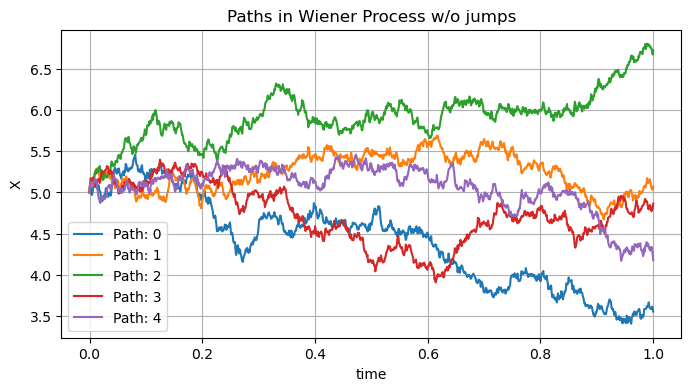

In [12]:
# SImulating A Wiener porcess without jumps. X
X_0 = 5
mu = 0.06
sigma = 0.3
X = [[] for _ in range(N)]
for path in range(N):
    X[path].append(X_0)
    x1 = seeds[path]
    x2 = seeds[(path + 6)%N]
    # Now empolying the recursive formula, W(ti+1) = W(ti) + sqrt(ti+1 - ti)*Z(i+1)
    for i in range(1000):
        Zi_1, Z_i_1, x1, x2 = normal_generator(x1, x2)
        X[path].append(X[path][i] + (mu - (sigma**2)/2)*(t[i+1] - t[i]) + math.sqrt(t[i+1] - t[i])*Zi_1)

plt.figure(figsize=(8, 4))
for path in range(N):
    plt.plot(t, X[path], label=f'Path: {path}')

plt.title("Paths in Wiener Process w/o jumps")
plt.xlabel('time')
plt.ylabel('X')
plt.legend()
plt.grid(True)
plt.show()

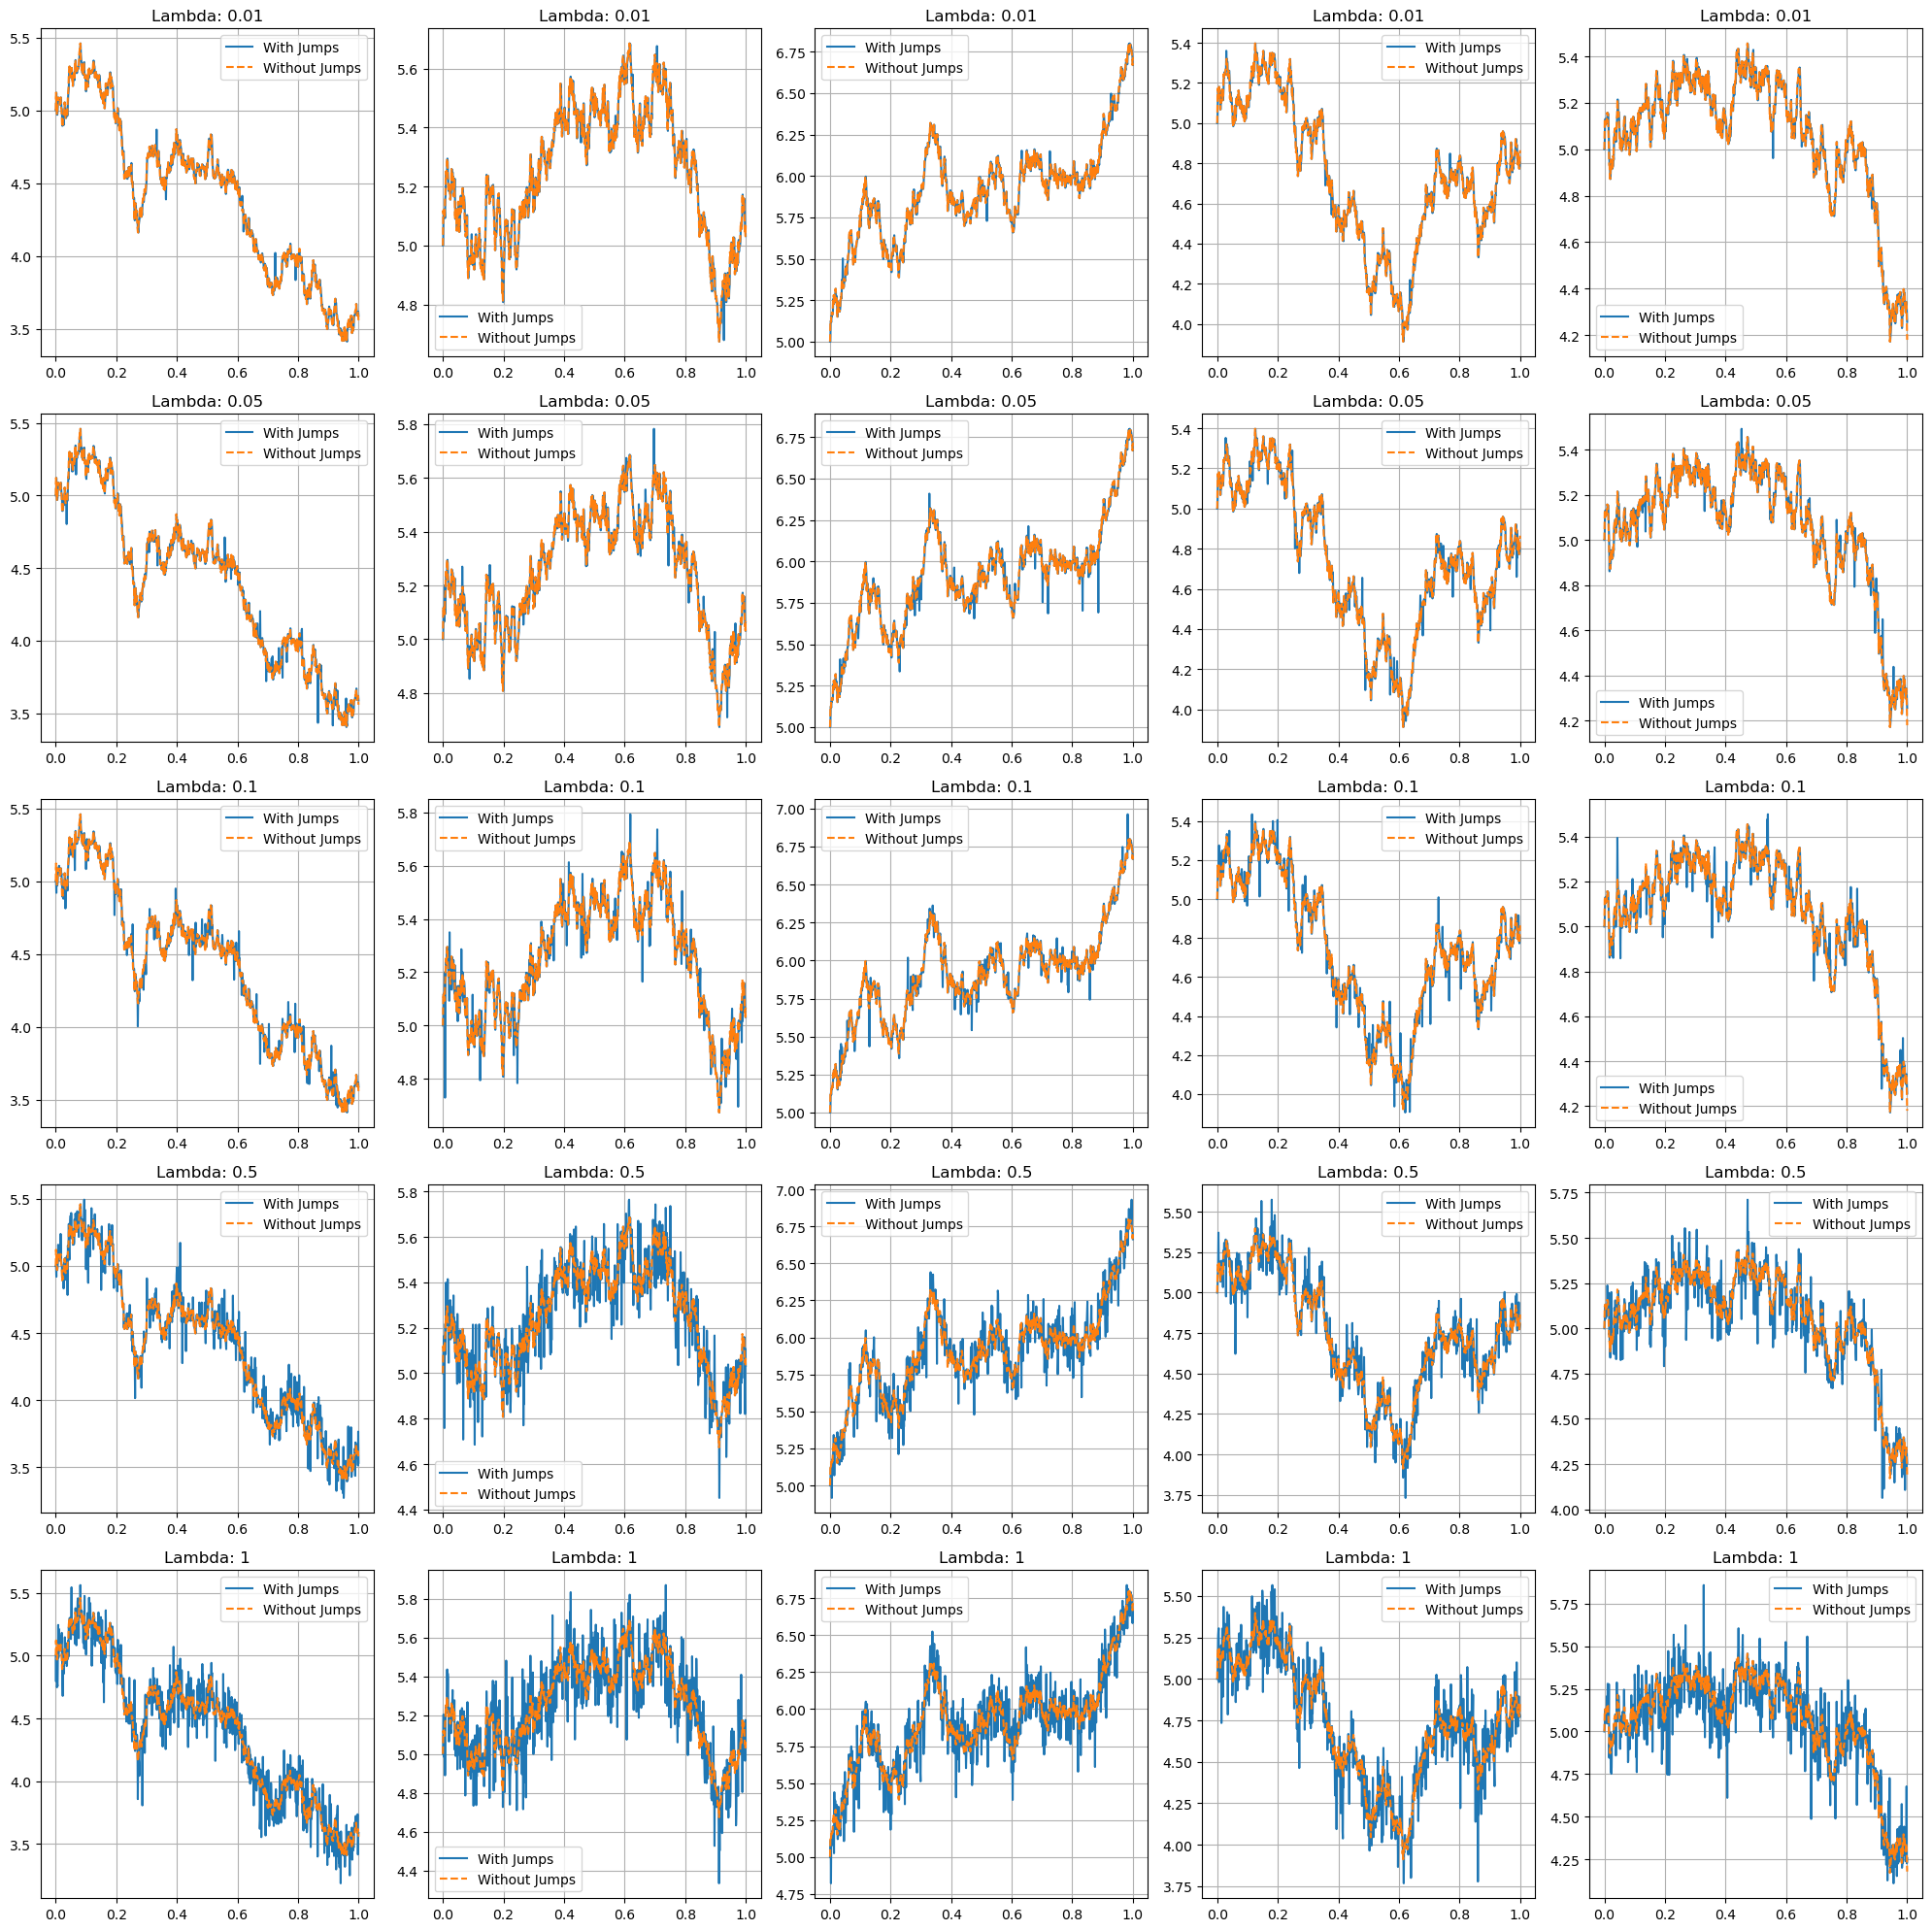

In [13]:
# Simulating a Wiener Process with Jumps(sampled from a Poisson Distribution).
lambdas = [0.01, 0.05, 0.1, 0.5, 1]
fig, axes = plt.subplots(5, 5, figsize=(20, 20))
count = 0
for l in lambdas:
    X_j = [[] for _ in range(N)]
    for path in range(N):
        X_j[path].append(X_0)
        seed = seeds[(path + 7)%N]
        np.random.seed((int)(seed))
        for i in range(1000):
            jump = 0
            num_jumps = np.random.poisson(l)  # Poisson jumps
            jump = np.sum(np.log(0.1 * np.random.normal(0, 1, num_jumps) + 1)) if num_jumps > 0 else 0
            # Update process
            X_j[path].append(X[path][i] + jump)
        axes[count, path].set_title(f"Lambda: {l}")
        axes[count, path].plot(t, X_j[path], label = f'With Jumps')
        axes[count, path].plot(t, X[path], label = f"Without Jumps", linestyle='dashed')
        axes[count, path].grid(True)
        axes[count, path].legend()
    count += 1

plt.tight_layout()
plt.show()
    

## end